##### Here we will do the finetuning process using the full model

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)
import pandas as pd
import numpy as np
from utils import make_vocab, stoi, training_loop
from model import CustomResNet
from dataset import CocoDataset
from tqdm import tqdm, trange
from torchvision.transforms import Compose, Resize, Normalize, CenterCrop
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [3]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs_coco_full/exp_1_1e-2/')

In [4]:
image_captions_df = pd.read_parquet('F://coco/captions/image_captions_df_less_than_15.parquet')
def make_vocab(token_list):
    """ This function takes in a token list and adds the unique tokens to the vocabulary."""
    for tokens in  token_list:
        for token in tokens:
            if token in vocab_dict:
                vocab_dict[token] +=1
            else:
                vocab_dict[token] = 1
    return vocab_dict

def make_vocab_shortest(token):
    """ This function takes in a token list and adds the unique tokens to the vocabulary."""
    for word in token:
        if word in vocab_dict:
            vocab_dict[word] +=1
        else:
            vocab_dict[word] = 1
    return vocab_dict

def stoi(captions_list, chartoidx):
    """ Function to convert the string tokens to integers.
        Also adds the <start>, <end> & <unk> tokens to form the final list to be fed in the RNN
        INPUT --> list of captions with 
        OUPUT --> """
    caption_token_list = []
    for caption in captions_list:
        tokens_list = [chartoidx['<start>']] + []
        for token in caption:
            try:
                tokens_list.append(chartoidx[token])
            except:
                tokens_list.append(chartoidx['<unk>'])
        tokens_list = tokens_list + [chartoidx['<end>']]
        caption_token_list.append(tokens_list)
    return caption_token_list


def convert_shortest_token(token_list,chartoidx):
    new_token_list = [chartoidx['<start>']]
    for token in token_list:
        new_token_list = new_token_list  + [chartoidx[token]]
    new_token_list = new_token_list + [chartoidx['<end>']]
    return new_token_list

vocab_dict = {}
image_captions_df['shortest_token'].apply(lambda x : make_vocab_shortest(x))

chartoidx = {}    # create the character to index dictionary for tokens and their integer representations.
idxtochar = []    # index to char list. Useful for decoding the output from the neural net. 
for i,word in enumerate(vocab_dict.keys()):
    chartoidx[word] = i
    idxtochar.append(word)

idxtochar = idxtochar + ['<unk>','<start>','<end>','<pad>']    # add additional tokens
chartoidx.update({'<unk>':10932,                       # add addtional tokens and their corresponding numbers 
                        '<start>':10933,
                        '<end>':10934,
                        '<pad>':10935})

# Add an idx_tokens column to the dataframe to house the integer representation of the token strings.
image_captions_df['shortest_idx_tokens'] = image_captions_df['shortest_token'].apply(lambda x : convert_shortest_token(x, chartoidx))
image_captions_df

,image_id,file_name,captions,caption_token_set,idx_captions,tokens,shortest_token,shortest_token_len,shortest_idx_tokens
0,57870,COCO_train2014_000000057870.jpg,"[[a, restaurant, has, modern, wooden, tables, ...","[arrangement, is, flower, on, table, blue, top...","[[27, 13, 25, 23, 9, 30, 12, 19], [27, 22, 13,...","[[a, restaurant, has, modern, wooden, tables, ...","[a, table, is, adorned, with, wooden, chairs, ...",11,"[10933, 0, 1, 2, 3, 4, 5, 6, 4, 7, 8, 9, 10934]"
1,384029,COCO_train2014_000000384029.jpg,"[[a, man, preparing, desserts, in, a, kitchen,...","[types, desserts, person, is, kitchen, many, u...","[[27, 53, 56, 33, 29, 27, 35, 42, 29, 50], [27...","[[a, man, preparing, desserts, in, a, kitchen,...","[close, up, of, a, hand, touching, various, pa...",9,"[10933, 10, 11, 12, 0, 13, 14, 15, 16, 9, 10934]"
2,222016,COCO_train2014_000000222016.jpg,"[[a, big, red, telephone, booth, that, a, man,...","[inside, person, image, standing, is, an, that...","[[27, 66, 62, 67, 65, 61, 27, 53, 1, 59, 29], ...","[[a, big, red, telephone, booth, that, a, man,...","[a, man, using, a, phone, in, a, phone, booth, .]",10,"[10933, 0, 17, 18, 0, 19, 20, 0, 19, 21, 9, 10..."
3,520950,COCO_train2014_000000520950.jpg,"[[the, kitchen, is, full, of, spices, on, the,...","[is, on, that, kitchen, all, utilizes, with, i...","[[20, 35, 1, 73, 28, 80, 3, 20, 75], [27, 35, ...","[[the, kitchen, is, full, of, spices, on, the,...","[a, very, small, kitchen, with, a, stove, and,...",12,"[10933, 0, 22, 23, 24, 4, 0, 25, 26, 0, 27, 12..."
4,69675,COCO_train2014_000000069675.jpg,"[[a, child, and, woman, are, cooking, in, the,...","[child, woman, person, on, women, an, together...","[[27, 88, 12, 89, 94, 98, 29, 20, 99], [27, 89...","[[a, child, and, woman, are, cooking, in, the,...","[two, women, cooking, on, stove, in, a, kitche...",10,"[10933, 29, 30, 31, 32, 25, 20, 0, 24, 33, 9, ..."
...,...,...,...,...,...,...,...,...,...
66657,53136,COCO_train2014_000000053136.jpg,"[[vegetable, and, rice, dish, served, in, a, w...","[bed, vegetables, on, white, top, with, pasta,...","[[2753, 12, 2778, 339, 995, 29, 27, 118, 358],...","[[vegetable, and, rice, dish, served, in, a, w...","[a, white, bowl, contains, shredded, cabbage, ...",9,"[10933, 0, 169, 281, 1033, 2233, 1767, 26, 117..."
66658,360271,COCO_train2014_000000360271.jpg,"[[women, sitting, at, a, dinner, table, with, ...","[woman, another, dinner., sitting, is, watchin...","[[90, 215, 102, 27, 311, 4, 7, 140, 145, 102, ...","[[women, sitting, at, a, dinner, table, with, ...","[a, bunch, of, women, are, eating, at, a, table]",9,"[10933, 0, 106, 12, 30, 214, 389, 336, 0, 1, 1..."
66660,444010,COCO_train2014_000000444010.jpg,"[[a, group, of, friends, sitting, down, at, a,...","[woman, jovial, sitting, table, group, togethe...","[[27, 362, 28, 2829, 215, 144, 102, 27, 4, 330...","[[a, group, of, friends, sitting, down, at, a,...","[a, jovial, older, couple, and, a, young, woma...",14,"[10933, 0, 2839, 1195, 293, 26, 0, 72, 139, 15..."
66661,565004,COCO_train2014_000000565004.jpg,"[[wine, being, poured, into, a, glass, over, a...","[another, is, on, table, wine, with, red, glas...","[[418, 319, 6776, 161, 27, 686, 139, 27, 4], [...","[[wine, being, poured, into, a, glass, over, a...","[a, wine, glass, being, filled, with, red, win...",9,"[10933, 0, 631, 277, 108, 61, 4, 93, 631, 9, 1..."


In [5]:
# make the test_image_captions_df from the original_df
test_indexes = torch.randint(0,len(image_captions_df), size=(1,int(0.20*len(image_captions_df)))).squeeze(0).numpy()
test_image_captions_df = image_captions_df.iloc[test_indexes]
image_captions_df.reset_index(drop = True, inplace=True)
image_captions_df.drop(test_indexes, inplace=True)
image_captions_df.reset_index(drop = True, inplace=True)

# make the _image_captions_df from the original_df
val_indexes = torch.randint(0,len(image_captions_df), size=(1,int(0.10*len(image_captions_df)))).squeeze(0).numpy()
val_image_captions_df = image_captions_df.iloc[val_indexes]
image_captions_df.reset_index(drop = True, inplace=True)
image_captions_df.drop(val_indexes, inplace=True)
image_captions_df.reset_index(drop = True, inplace=True)

In [6]:
print(len(image_captions_df), len(test_image_captions_df), len(val_image_captions_df))

46477 12545 5136


In [24]:
manual_transforms = Compose([
                            Resize(size = (256,256)),
                            CenterCrop(size=(224,224)),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
manual_transforms


test_coco = CocoDataset(image_label_df=test_image_captions_df, transforms=manual_transforms)
val_coco = CocoDataset(image_label_df=val_image_captions_df, transforms=manual_transforms)
train_coco = CocoDataset(image_label_df = image_captions_df, transforms=manual_transforms)

test_coco_dataloader = DataLoader(dataset=test_coco,shuffle=True, pin_memory=True,num_workers=2,batch_size = 1)
val_coco_dataloader = DataLoader(dataset=val_coco,shuffle = True, pin_memory=True,num_workers=2,batch_size = 1)
train_coco_dataloader = DataLoader(dataset = train_coco, shuffle = True, pin_memory=True,num_workers=2,batch_size = 1)

In [25]:
# Lets create another custome resnet model
class CustResnetRnn(nn.Module):
    def __init__(self, chartoidx, idxtochar):
        super().__init__()

        self.chartoidx = chartoidx
        self.idxtochar = idxtochar

        self.embedding_matrix = nn.Embedding(len(self.idxtochar), 15)
        
        self.rnn_cell = nn.RNNCell(input_size=15, hidden_size= 1000, nonlinearity='tanh')

        self.fc = nn.Linear(1000, len(idxtochar))

    def forward(self, hidden_state_vector, text_input):
        embedding  = self.embedding_matrix(text_input)
        # print(f"The shape of embedding is {embedding.shape}")
        hidden_state = self.rnn_cell(embedding, hidden_state_vector)  
        # out_hidden_state = hidden_state.clone()

        rnn_output = self.fc(hidden_state)

        return rnn_output, hidden_state

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cust_res_rnn = CustResnetRnn(chartoidx, idxtochar).to(device)

res_50 = torchvision.models.resnet50(weights =ResNet50_Weights.DEFAULT).to(device)
# for parameter in res_50.parameters():
#     parameter.requires_grad = False

In [27]:
def train_loop(train_dataloader, rnn_model, optimizer, res_50_model):
    """ This function takes in the model and the data and trains the model once on the whole dataset"""
    print("Training is progressing.....")
    batch_loss_list = []
    i = 1
    j=0
    # res_50_model = res_50_model.to(torch.device('cuda'))
    for batch in tqdm(train_dataloader):
        batch_loss = 0
        image, caption, _ = batch
        caption = caption[0]
        
        final_caption = caption[0:len(caption)-1].to(device = torch.device('cuda'))
        final_targets = caption[1:len(caption)].to(device = torch.device('cuda'))
        image = image.to(torch.device('cuda'))
        hidden_state = res_50_model(image)
        
        optimizer.zero_grad()

        # Now we would input the captions into the rnn one by one and start the generation process
        new_hidden_state = hidden_state.squeeze(0)
        
        for i in range(len(final_caption)):
            output, new_hidden_state =  rnn_model(new_hidden_state, final_caption[i])
            output_logits = output.clone()
            batch_loss += F.cross_entropy(output_logits,final_targets[i])
            

        batch_loss = (batch_loss/len(final_caption))
        batch_loss.backward()
        optimizer.step()
        
        batch_loss_list.append(batch_loss.item())
        # If the length of the list reaches 10000 then take the mean of last added 10000 elements and print the loss
        if len(batch_loss_list) == (i*10000):
            try:
                mean_loss = (batch_loss_list[j*10000:(j+1)*10000])/10000
                print(f"The mean loss of the previous 10000 train_batches is : {mean_loss}")
                i+=1
                j+=1
            except:
                continue
    return batch_loss.sum()/len(batch_loss_list)

def val_loop(val_dataloader, rnn_model,res_50_model):
    """ This function takes in the model and the data and validates the model once on the whole validation dataset"""
    print("Validation is progressing .....")
    with torch.no_grad():
        batch_loss_list = []
        i = 1
        j=0
        # res_50_model = res_50_model.to(torch.device('cuda'))
        for batch in tqdm(val_dataloader):
            batch_loss = 0
            image, caption, _ = batch
            caption = caption[0]
            
            final_caption = caption[0:len(caption)-1].to(device = torch.device('cuda'))
            final_targets = caption[1:len(caption)].to(device = torch.device('cuda'))
            image = image.to(torch.device('cuda'))
            hidden_state = res_50_model(image)
            
            # optimizer.zero_grad()

            # Now we would input the captions into the rnn one by one and start the generation process
            new_hidden_state = hidden_state.squeeze(0)
            
            for i in range(len(final_caption)):
                output, new_hidden_state =  rnn_model(new_hidden_state, final_caption[i])
                output_logits = output.clone()
                batch_loss += F.cross_entropy(output_logits,final_targets[i])
                

            batch_loss = (batch_loss/len(final_caption))
            # batch_loss.backward()
            # optimizer.step()
            
            batch_loss_list.append(batch_loss.item())
            # If the length of the list reaches 10000 then take the mean of last added 10000 elements and print the loss
            if len(batch_loss_list) == (i*1000):
                try:
                    mean_loss = (batch_loss_list[j*1000:(j+1)*1000])/1000
                    print(f"The mean loss of the previous 1000 val_batches is : {mean_loss}")
                    i+=1
                    j+=1
                except:
                    continue
    return batch_loss.sum()/len(batch_loss_list)

In [28]:
def engine(epochs, train_dataloader, val_dataloader, model, optimizer, res_50_model,tensorboard_writer):
    for epoch in range(epochs):
        # Get the training epoch loss for the current epoch
        train_epoch_loss = train_loop(train_dataloader,rnn_model=model,optimizer=optimizer, res_50_model=res_50_model)
        tensorboard_writer.add_scalar(tag = 'Training Loss per Epoch', scalar_value=train_epoch_loss, global_step = epoch)

        # Get the validation epoch loss for the current epoch
        val_epoch_loss = val_loop(val_dataloader,rnn_model=model, res_50_model=res_50_model)
        tensorboard_writer.add_scalar(tag = 'Validation Loss per Epoch', scalar_value = val_epoch_loss, global_step=epoch)

        print(f"Epoch : {epoch} | Training Loss : {train_epoch_loss} | Validation Loss : {val_epoch_loss}")

In [29]:
full_model_parameters = list(res_50.parameters()) + list(cust_res_rnn.parameters())
adam_optimizer = optim.Adam(full_model_parameters, lr = 0.001)

In [30]:
engine(10,
        train_dataloader = test_coco_dataloader,
        val_dataloader=val_coco_dataloader,
        model = cust_res_rnn,
        optimizer=adam_optimizer,
        res_50_model = res_50,
        tensorboard_writer=writer
        )

Training is progressing.....


100%|██████████| 12545/12545 [27:03<00:00,  7.73it/s] 


Validation is progressing .....


100%|██████████| 5136/5136 [03:38<00:00, 23.48it/s]


Epoch : 0 | Training Loss : 0.0006074472330510616 | Validation Loss : 0.0008974194643087685
Training is progressing.....


100%|██████████| 12545/12545 [27:26<00:00,  7.62it/s] 


Validation is progressing .....


100%|██████████| 5136/5136 [02:44<00:00, 31.20it/s]


Epoch : 1 | Training Loss : 0.00041966437129303813 | Validation Loss : 0.000974820286501199
Training is progressing.....


100%|██████████| 12545/12545 [27:29<00:00,  7.61it/s]


Validation is progressing .....


100%|██████████| 5136/5136 [03:06<00:00, 27.60it/s]


Epoch : 2 | Training Loss : 0.000587564310990274 | Validation Loss : 0.0009099416784010828
Training is progressing.....


100%|██████████| 12545/12545 [27:25<00:00,  7.62it/s]


Validation is progressing .....


100%|██████████| 5136/5136 [02:51<00:00, 30.02it/s]


Epoch : 3 | Training Loss : 0.00034508053795434535 | Validation Loss : 0.0006540213944390416
Training is progressing.....


  0%|          | 0/12545 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [32]:
torch.save(res_50,'trained_res_50.pth')
torch.save(cust_res_rnn,'re_50_cust_res_rnn.pth')

In [35]:
trained_res_50 = torch.load('trained_res_50.pth').to(torch.device('cpu'))
trained_cust_res_rnn = torch.load('re_50_cust_res_rnn.pth').to(torch.device('cpu'))

In [34]:
def inference(backbone, model, image_data,caption):
    with torch.no_grad():
        word_list = []
        hidden_backbone_vector = backbone(image_data).squeeze(0)
        start_token = torch.tensor(chartoidx['<start>'])
        in_char = start_token
        out_index = chartoidx['<start>']
        while idxtochar[out_index] != '<end>':
            rnn_output, hidden_backbone_vector = model(hidden_backbone_vector,in_char)
            out_index = torch.argmax(rnn_output)
            word_list.append(idxtochar[out_index])
            in_char = out_index
    plt.imshow(image_data.squeeze(0).permute(1,2,0).numpy())
    print(f"The correct caption is : {' '.join([idxtochar[x] for x in caption[1:]])}")
    print(f"The caption for the given image is : {' '.join(word_list)}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The correct caption is : a man looking at the produce hanging in a outdoor fruit stand . <end>
The caption for the given image is : a bathroom store with a laptop and soccer and tomato <end>


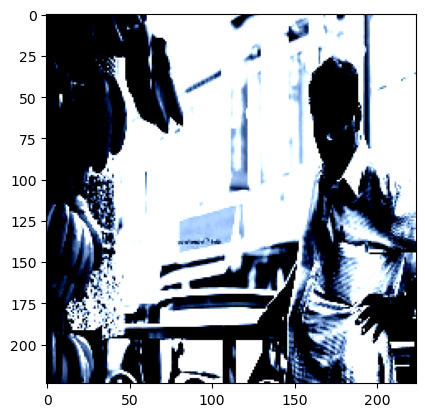

In [47]:
image, caption, _ = test_coco[333]
image = image.unsqueeze(0)
inference(backbone = trained_res_50, model = trained_cust_res_rnn, image_data=image, caption = caption)

In [ ]:
# Now we will define a new training loop to
def training_loop(epochs, train_dataloader, val_dataloader, model, optimizer, res_50_model):
    """ Function to create the training loop which would take in the image and the caption train on it word by word """
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(train_dataloader):
            batch_loss = 0
            image, caption, _ = batch
            caption = caption[0]
            
            final_caption = caption[0:len(caption)-1].to(device = torch.device('cuda'))
            final_targets = caption[1:len(caption)].to(device = torch.device('cuda'))
            image = image.to(torch.device('cuda'))
            hidden_state = res_50_model(image)
            
            optimizer.zero_grad()

            # Now we would input the captions into the rnn one by one and start the generation process
            new_hidden_state = hidden_state.squeeze(0)
            
            for i in range(len(final_caption)):
                output, new_hidden_state =  model(new_hidden_state, final_caption[i])
                # target_tensor = torch.zeros(output.shape)
                
                # target_tensor[targets[i]] = 1
                # print(target_tensor.shape)
                output_logits = output.clone()
                batch_loss += F.cross_entropy(output_logits,final_targets[i])
                # print(loss)
            batch_loss = (batch_loss/len(final_caption))
            batch_loss.backward()
            optimizer.step()
            # print(batch_loss)
            # print(batch_loss)
            epoch_loss += batch_loss.item()
        print(f"The loss is {epoch_loss/len(train_dataloader)}")